In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
df = pd.read_csv('data/train.csv')
# drop the first column
df = df.iloc[:,1:]
sampled_data = df.sample(n=800, random_state=42)
sampled_data.shape
X = sampled_data.iloc[:, :-1]
y = sampled_data['Response']

In [3]:
nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve

In [4]:
# needs to be done manually
ordinal_ftrs = ['Vehicle_Age'] 
ordinal_cats = [['< 1 Year','1-2 Year','> 2 Years']]
onehot_ftrs = ['Gender','Vehicle_Damage']
minmax_ftrs = ['Age']
std_ftrs = ['Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)],
remainder='passthrough' )

prep = Pipeline(steps=[('preprocessor', preprocessor)])

Random State 1
Best Parameters: {'ML_algo__max_depth': 5, 'ML_algo__max_features': 1.0}


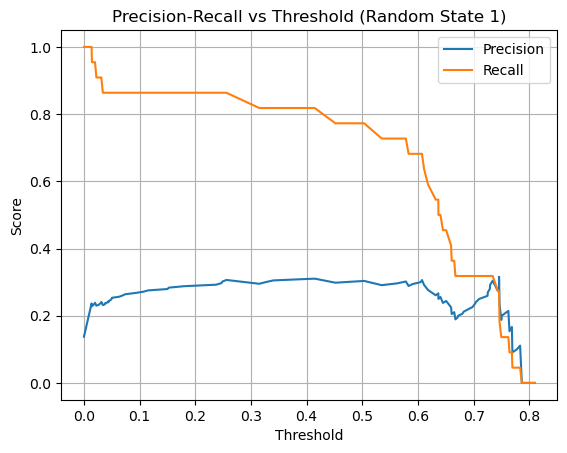

Best Threshold for F1-Score: 0.26
Test Metrics with Adjusted Threshold - Precision: 0.3065, Recall: 0.8636, F1-Score: 0.4524


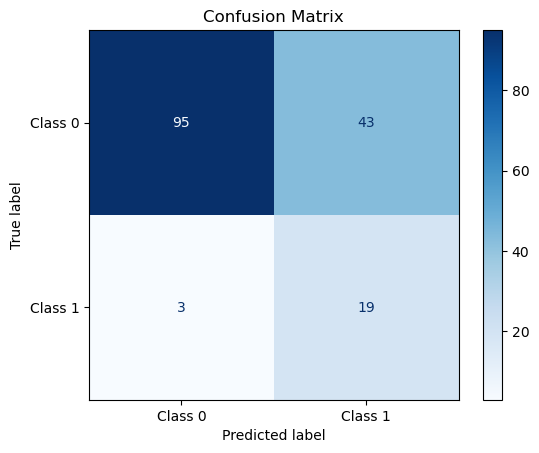

Random State 2


KeyboardInterrupt: 

In [5]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold


# rf
nr_states = 5
test_scores11 = np.zeros(nr_states)
best_thresholds11 = np.zeros(nr_states)
final_models11 = []
precisions11 = np.zeros(nr_states)
recalls11 = np.zeros(nr_states)
  # Assuming `prep` is already defined

for i in range(nr_states):
    print(f"Random State {i+1}")
    
    # Split data into training and test sets
    X_other, X_test, y_other, y_test = train_test_split(X,y,\
                    train_size = 0.8,stratify=y,random_state = 42*i)
    
    # Define parameter grid for RandomForestClassifier
    param_grid = {
        'ML_algo__max_depth': [5,7,10,15,50],
        'ML_algo__max_features': [0.4,0.6,0.8,1.0]
    }

    # preprocess the sets
    X_other_prep = prep.fit_transform(X_other)
    
    # Define the pipeline with preprocessing and the model
    clf = Pipeline(steps=[
        ('ML_algo', RandomForestClassifier(class_weight='balanced', random_state=42*i))
    ])

    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    #StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(clf, param_grid, cv=kfold, scoring='f1',verbose=0, n_jobs=-1)
    grid_search.fit(X_other_prep, y_other)
        #print("Best parameters: ", grid_search.best_params_)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best Parameters: {best_params}")
    
    # Evaluate on validation and test sets
    X_test_prep = prep.transform(X_test)  # Transform the test data
    y_test_probs = best_model.predict_proba(X_test_prep)[:, 1]
    
    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs)
    
    # Plot Precision-Recall vs Threshold
    plt.figure()
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision-Recall vs Threshold (Random State {i+1})")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Compute F1-scores for each threshold
    f1_scores = [f1_score(y_test, (y_test_probs >= t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Best Threshold for F1-Score: {best_threshold:.2f}")
    
    # Evaluate using the best threshold
    y_test_pred_adjusted = (y_test_probs >= best_threshold).astype(int)
    precision_test = precision_score(y_test, y_test_pred_adjusted)
    recall_test = recall_score(y_test, y_test_pred_adjusted)
    f1_test = f1_score(y_test, y_test_pred_adjusted)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred_adjusted)
    precisions11[i]=precision_test
    recalls11[i] = recall_test
    print(f"Test Metrics with Adjusted Threshold - Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-Score: {f1_test:.4f}")

    
    # # Print metrics for each class
    # for i, cls in enumerate(set(y_test)):
    #     print(f"Class {cls}:")
    #     print(f"  Precision: {precision[i]:.4f}")
    #     print(f"  Recall: {recall[i]:.4f}")
    #     print(f"  F1-Score: {f1[i]:.4f}")
    #     print(f"  Support: {support[i]}")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred_adjusted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    
    
    # Save the best model
    final_models11.append(best_model)
    test_scores11[i] = f1_test
    best_thresholds11[i] = best_threshold

Random State 1
Best Parameters: {'ML_algo__max_depth': 5, 'ML_algo__max_features': 0.6}


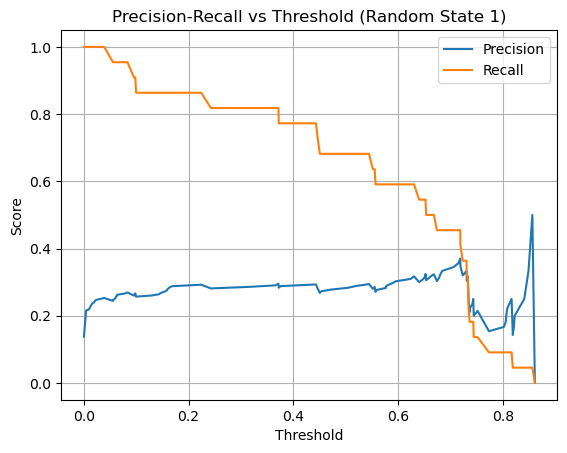

Best Threshold for F1-Score: 0.22
Test Metrics with Adjusted Threshold - Precision: 0.2923, Recall: 0.8636, F1-Score: 0.4368


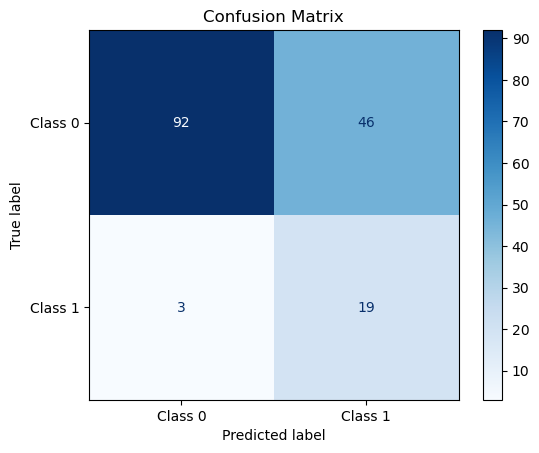

Random State 2
Best Parameters: {'ML_algo__max_depth': 5, 'ML_algo__max_features': 0.8}


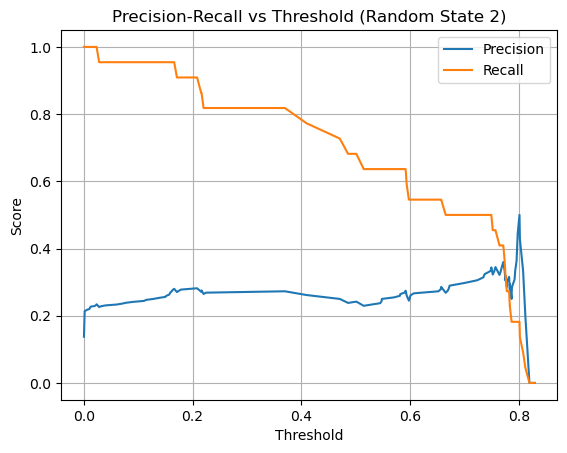

Best Threshold for F1-Score: 0.17
Test Metrics with Adjusted Threshold - Precision: 0.2800, Recall: 0.9545, F1-Score: 0.4330


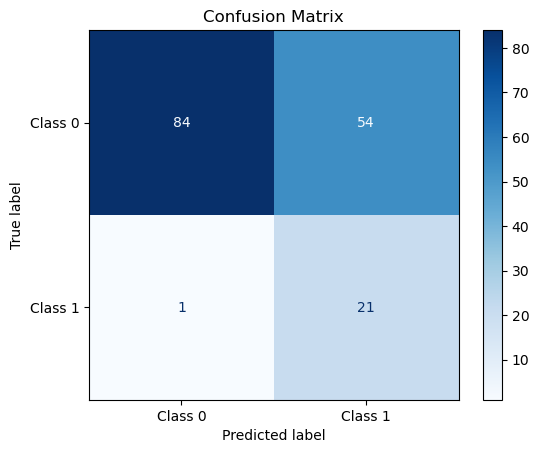

Random State 3
Best Parameters: {'ML_algo__max_depth': 5, 'ML_algo__max_features': 1.0}


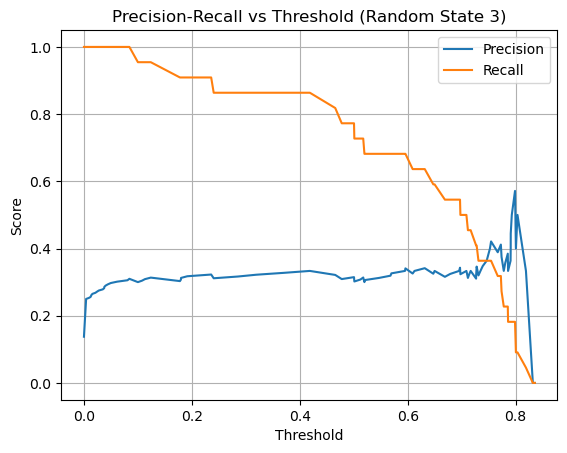

Best Threshold for F1-Score: 0.42
Test Metrics with Adjusted Threshold - Precision: 0.3333, Recall: 0.8636, F1-Score: 0.4810


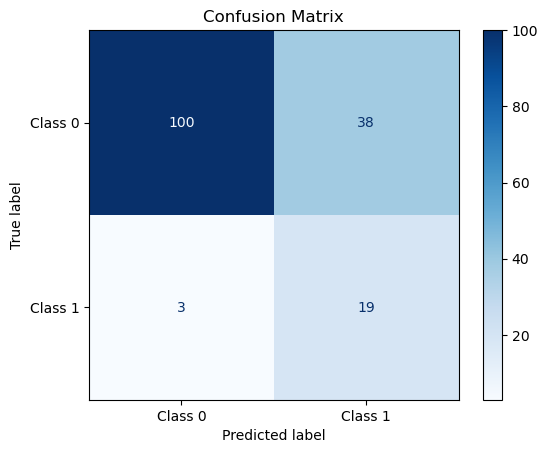

Random State 4
Best Parameters: {'ML_algo__max_depth': 5, 'ML_algo__max_features': 0.4}


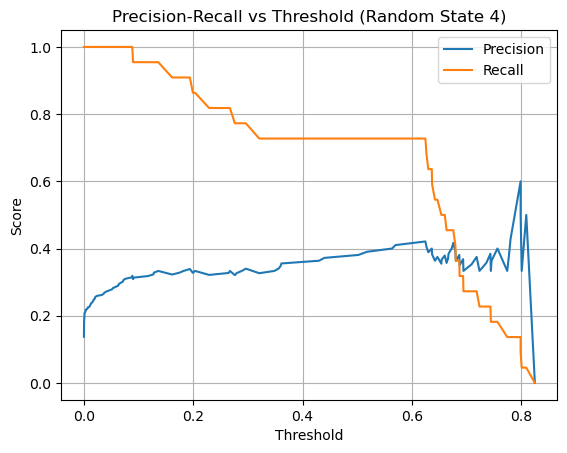

Best Threshold for F1-Score: 0.62
Test Metrics with Adjusted Threshold - Precision: 0.4211, Recall: 0.7273, F1-Score: 0.5333


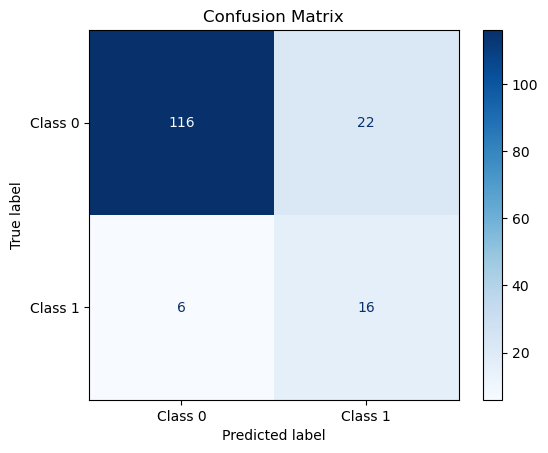

Random State 5
Best Parameters: {'ML_algo__max_depth': 5, 'ML_algo__max_features': 0.4}


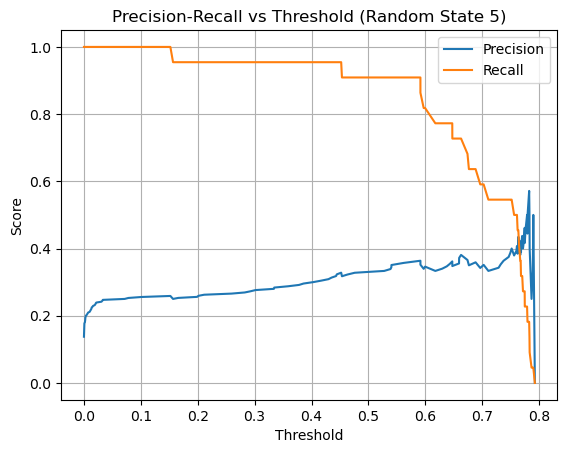

Best Threshold for F1-Score: 0.59
Test Metrics with Adjusted Threshold - Precision: 0.3636, Recall: 0.9091, F1-Score: 0.5195


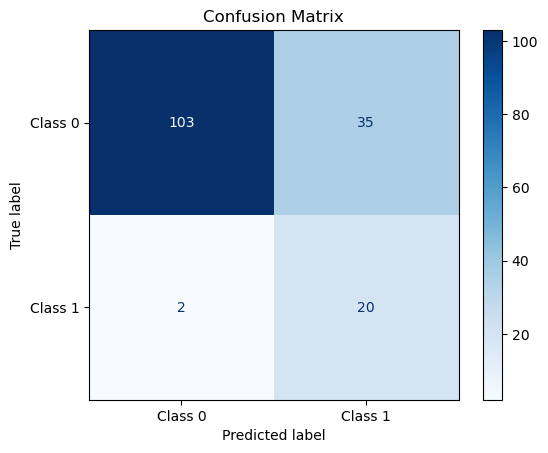

In [6]:
#rf - smote


# Define the number of random states for testing
nr_states = 5
test_scores12 = np.zeros(nr_states)
best_thresholds12 = np.zeros(nr_states)
final_models12 = []
precisions12 = np.zeros(nr_states)
recalls12 = np.zeros(nr_states)
  # Assuming `prep` is already defined

for i in range(nr_states):
    print(f"Random State {i+1}")
    
    # Split data into training and test sets
    X_other, X_test, y_other, y_test = train_test_split(X,y,\
                    train_size = 0.8,stratify=y,random_state = 42*i)
    
    # Define parameter grid for RandomForestClassifier
    param_grid = {
        'ML_algo__max_depth': [5,7,10,15,50],
        'ML_algo__max_features': [0.4,0.6,0.8,1.0]
    }


    
    # preprocess the sets
    X_other_prep = prep.fit_transform(X_other)
    
    # Define the pipeline with preprocessing and the model
    clf = ImbPipeline(steps=[
        ('smote', SMOTE(sampling_strategy=0.5, k_neighbors=10, random_state=42*i)),
        ('ML_algo', RandomForestClassifier(class_weight='balanced', random_state=42*i))
    ])

    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    #StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(clf, param_grid, cv=kfold, scoring='f1',verbose=0, n_jobs=-1)
    grid_search.fit(X_other_prep, y_other)
        #print("Best parameters: ", grid_search.best_params_)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best Parameters: {best_params}")
    
    # Evaluate on validation and test sets
    X_test_prep = prep.transform(X_test)  # Transform the test data
    y_test_probs = best_model.predict_proba(X_test_prep)[:, 1]
    
    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs)
    
    # Plot Precision-Recall vs Threshold
    plt.figure()
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision-Recall vs Threshold (Random State {i+1})")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Compute F1-scores for each threshold
    f1_scores = [f1_score(y_test, (y_test_probs >= t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Best Threshold for F1-Score: {best_threshold:.2f}")
    
    # Evaluate using the best threshold
    y_test_pred_adjusted = (y_test_probs >= best_threshold).astype(int)
    precision_test = precision_score(y_test, y_test_pred_adjusted)
    recall_test = recall_score(y_test, y_test_pred_adjusted)
    f1_test = f1_score(y_test, y_test_pred_adjusted)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred_adjusted)
    precisions12[i] = precision_test
    recalls12[i] = recall_test
    print(f"Test Metrics with Adjusted Threshold - Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-Score: {f1_test:.4f}")

    cm = confusion_matrix(y_test, y_test_pred_adjusted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    
    # # Print metrics for each class
    # for i, cls in enumerate(set(y_test)):
    #     print(f"Class {cls}:")
    #     print(f"  Precision: {precision[i]:.4f}")
    #     print(f"  Recall: {recall[i]:.4f}")
    #     print(f"  F1-Score: {f1[i]:.4f}")
    #     print(f"  Support: {support[i]}")


    
    # # Compute Precision-Recall Curve and AUC-PR
    # precision, recall, _ = precision_recall_curve(y_test, y_test_probs)
    # auc_pr = average_precision_score(y_test, y_test_probs)
    # print(f"Precision-Recall AUC: {auc_pr:.4f}")
    # plt.figure()
    # plt.plot(recall, precision, marker='.', label=f"AUC-PR: {auc_pr:.4f}")
    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.title('Precision-Recall Curve')
    # plt.legend()
    # plt.show()
    
    # Save the best model
    final_models12.append(best_model)
    test_scores12[i] = f1_test
    best_thresholds12[i] = best_threshold

In [75]:
print(test_scores12.mean())
test_scores11.mean()

0.4346990339055769


0.44156304239895555

Random State 1
Best Parameters: {'ML_algo__learning_rate': 0.01, 'ML_algo__max_depth': 5, 'ML_algo__n_estimators': 50}


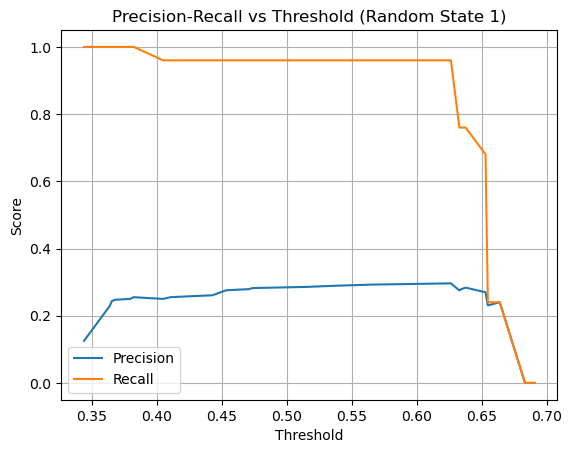

Best Threshold for F1-Score: 0.63
Test Metrics with Adjusted Threshold - Precision: 0.2963, Recall: 0.9600, F1-Score: 0.4528


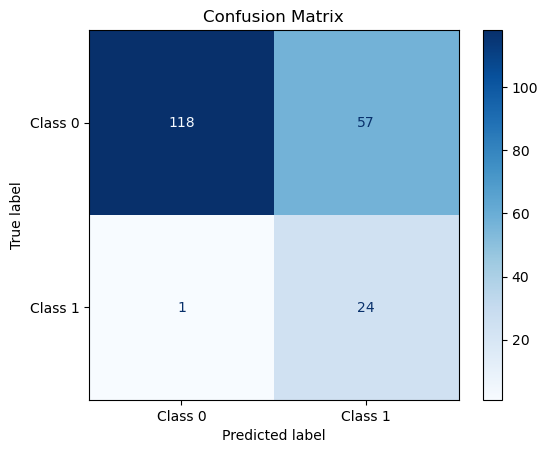

Random State 2
Best Parameters: {'ML_algo__learning_rate': 0.01, 'ML_algo__max_depth': 5, 'ML_algo__n_estimators': 150}


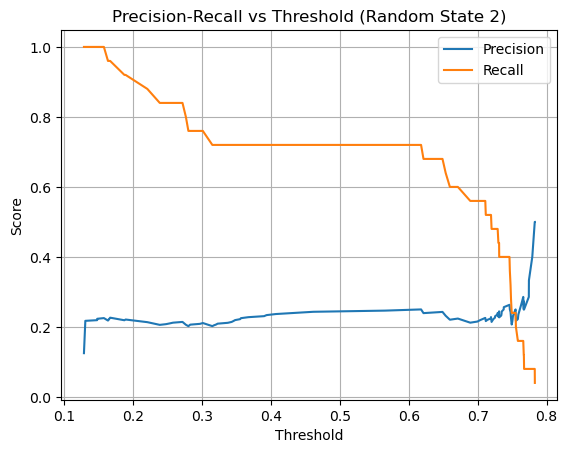

Best Threshold for F1-Score: 0.62
Test Metrics with Adjusted Threshold - Precision: 0.2500, Recall: 0.7200, F1-Score: 0.3711


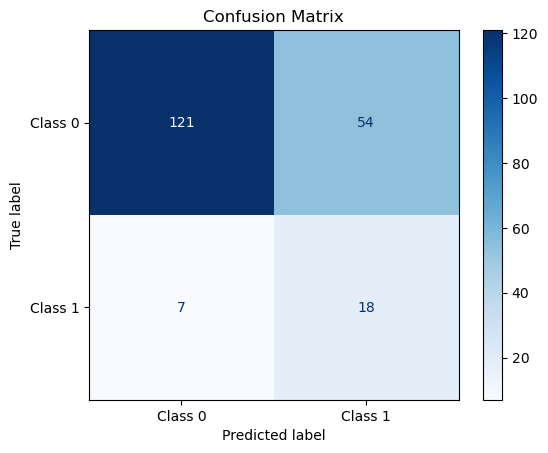

Random State 3
Best Parameters: {'ML_algo__learning_rate': 0.01, 'ML_algo__max_depth': 5, 'ML_algo__n_estimators': 200}


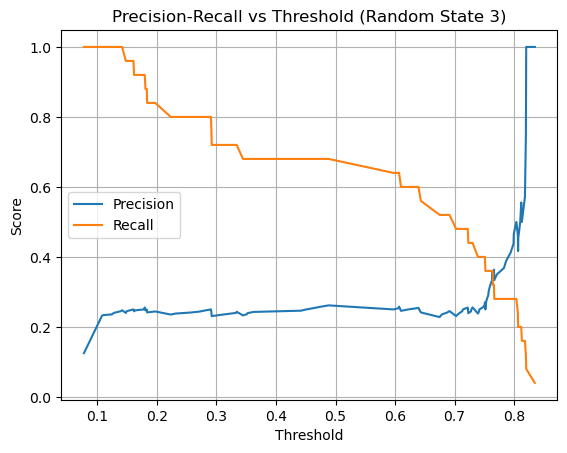

Best Threshold for F1-Score: 0.18
Test Metrics with Adjusted Threshold - Precision: 0.2556, Recall: 0.9200, F1-Score: 0.4000


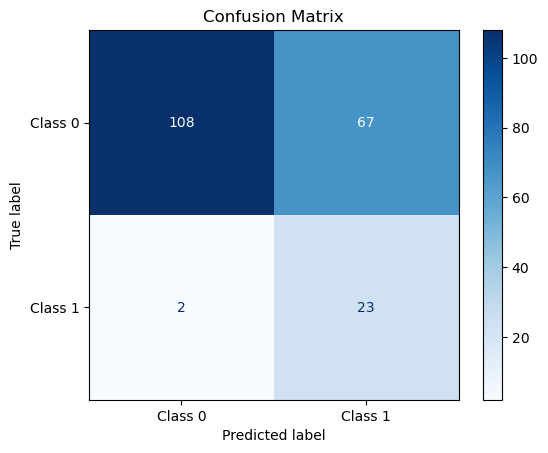

Random State 4
Best Parameters: {'ML_algo__learning_rate': 0.01, 'ML_algo__max_depth': 5, 'ML_algo__n_estimators': 150}


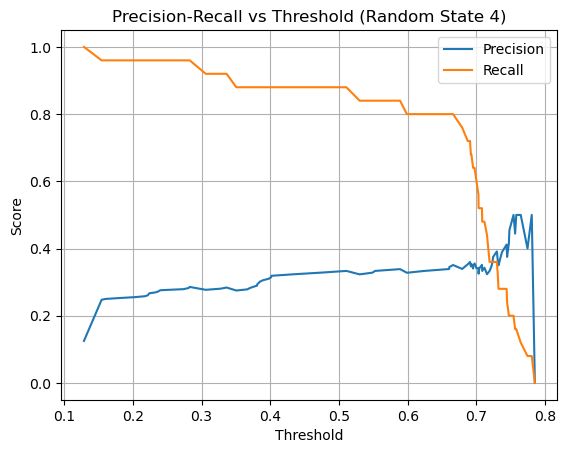

Best Threshold for F1-Score: 0.67
Test Metrics with Adjusted Threshold - Precision: 0.3509, Recall: 0.8000, F1-Score: 0.4878


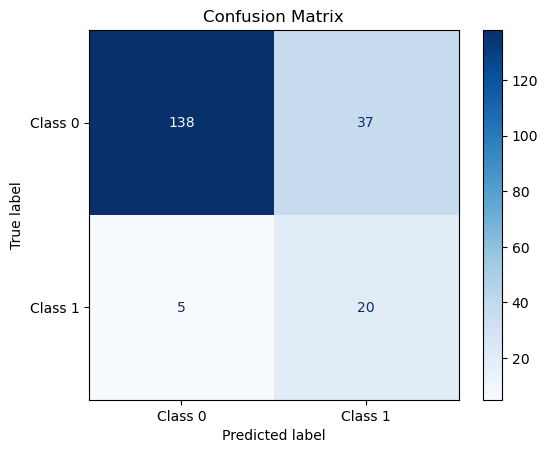

Random State 5
Best Parameters: {'ML_algo__learning_rate': 0.01, 'ML_algo__max_depth': 5, 'ML_algo__n_estimators': 50}


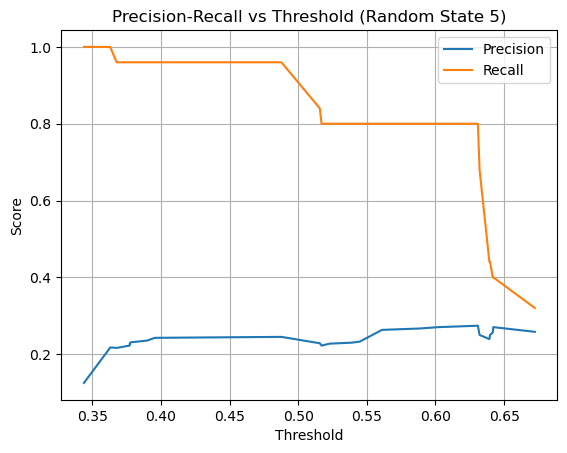

Best Threshold for F1-Score: 0.63
Test Metrics with Adjusted Threshold - Precision: 0.2740, Recall: 0.8000, F1-Score: 0.4082


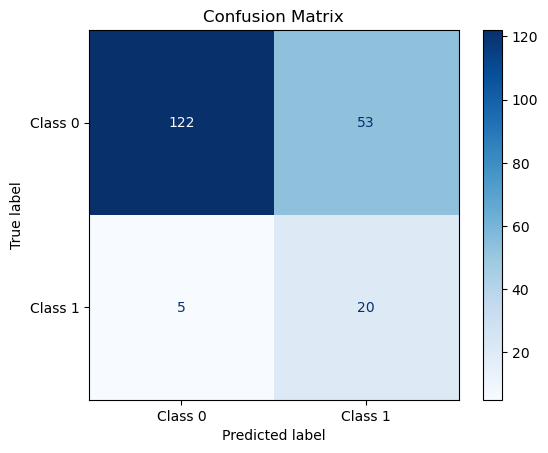

In [77]:
#xgb
from xgboost import XGBClassifier

nr_states = 5
test_scores21 = np.zeros(nr_states)
best_thresholds21 = np.zeros(nr_states)
final_models21 = []
recalls21 = np.zeros(nr_states)
precisions21 = np.zeros(nr_states)
  # Assuming `prep` is already defined

for i in range(nr_states):
    print(f"Random State {i+1}")
    
    # Split data into training and test sets
    X_other, X_test, y_other, y_test = train_test_split(X,y,\
                    train_size = 0.8,stratify=y,random_state = 42*i)
    
    # Define parameter grid for RandomForestClassifier
    param_grid = {
    'ML_algo__max_depth': [5, 10, 15],
    'ML_algo__learning_rate': [0.01, 0.1, 0.2],
    'ML_algo__n_estimators': [50, 75, 100, 150, 200]
}


    # preprocess the sets
    X_other_prep = prep.fit_transform(X_other)
    
    # Define the pipeline with preprocessing and the model
    clf = Pipeline(steps=[
        ('ML_algo', XGBClassifier(objective='binary:logistic', scale_pos_weight=9, random_state=42*i))
    ])
    
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    #StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(clf, param_grid, cv=kfold, scoring='f1',verbose=0, n_jobs=-1)
    grid_search.fit(X_other_prep, y_other)
        #print("Best parameters: ", grid_search.best_params_)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best Parameters: {best_params}")
    
    # Evaluate on validation and test sets
    X_test_prep = prep.transform(X_test)  # Transform the test data
    y_test_probs = best_model.predict_proba(X_test_prep)[:, 1]
    
    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs)
    
    # Plot Precision-Recall vs Threshold
    plt.figure()
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision-Recall vs Threshold (Random State {i+1})")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Compute F1-scores for each threshold
    f1_scores = [f1_score(y_test, (y_test_probs >= t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Best Threshold for F1-Score: {best_threshold:.2f}")
    
    # Evaluate using the best threshold
    y_test_pred_adjusted = (y_test_probs >= best_threshold).astype(int)
    precision_test = precision_score(y_test, y_test_pred_adjusted)
    recall_test = recall_score(y_test, y_test_pred_adjusted)
    f1_test = f1_score(y_test, y_test_pred_adjusted)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred_adjusted)
    precisions21[i] = precision_test
    recalls21[i] = recall_test
    test_scores21[i] = f1_test
    #ptrint detailed metrics
    print(f"Test Metrics with Adjusted Threshold - Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-Score: {f1_test:.4f}")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred_adjusted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
    final_models21.append(best_model)
    best_thresholds21[i] = best_threshold

Random State 1
Best Parameters: {'ML_algo__learning_rate': 0.01, 'ML_algo__max_depth': 5, 'ML_algo__n_estimators': 150}


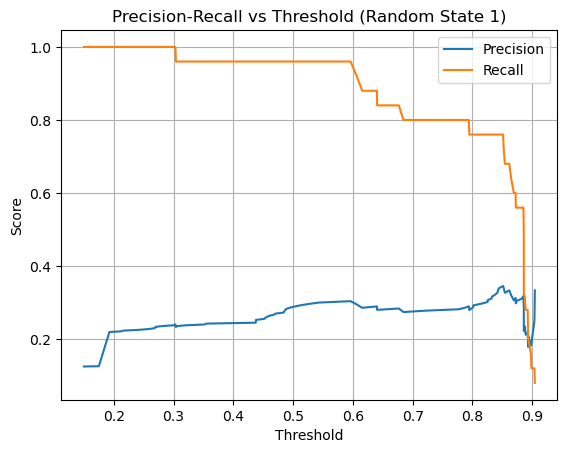

Best Threshold for F1-Score: 0.85
Test Metrics with Adjusted Threshold - Precision: 0.3455, Recall: 0.7600, F1-Score: 0.4750


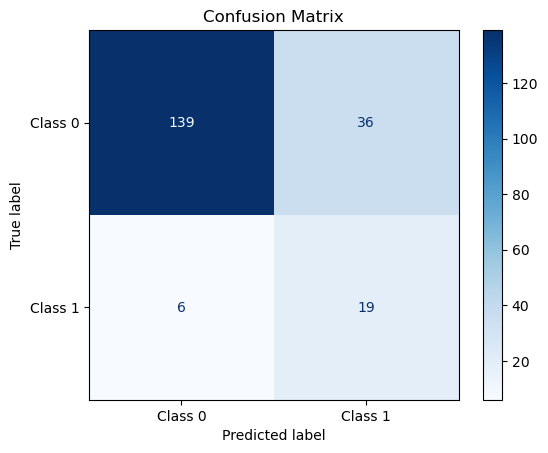

Random State 2
Best Parameters: {'ML_algo__learning_rate': 0.01, 'ML_algo__max_depth': 5, 'ML_algo__n_estimators': 200}


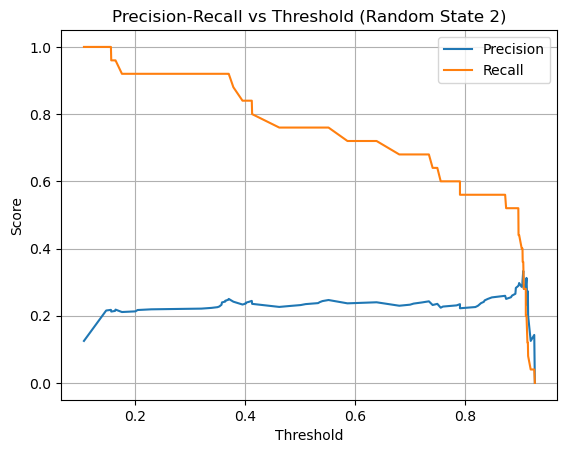

Best Threshold for F1-Score: 0.37
Test Metrics with Adjusted Threshold - Precision: 0.2500, Recall: 0.9200, F1-Score: 0.3932


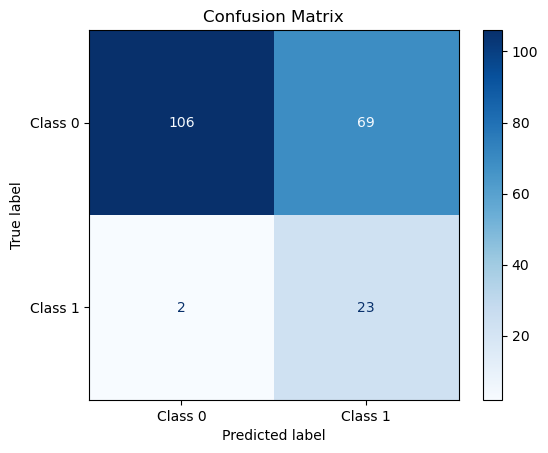

Random State 3
Best Parameters: {'ML_algo__learning_rate': 0.01, 'ML_algo__max_depth': 5, 'ML_algo__n_estimators': 150}


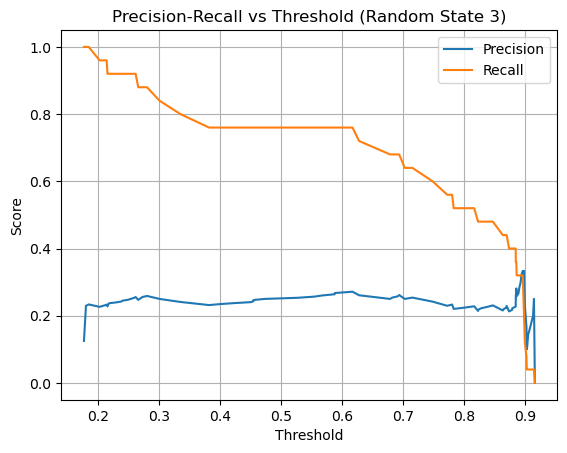

Best Threshold for F1-Score: 0.26
Test Metrics with Adjusted Threshold - Precision: 0.2556, Recall: 0.9200, F1-Score: 0.4000


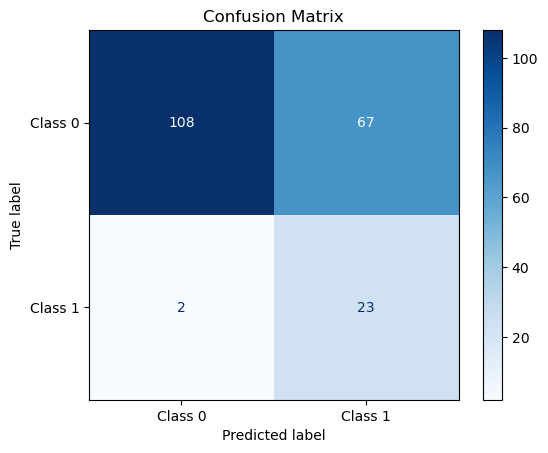

Random State 4
Best Parameters: {'ML_algo__learning_rate': 0.01, 'ML_algo__max_depth': 5, 'ML_algo__n_estimators': 100}


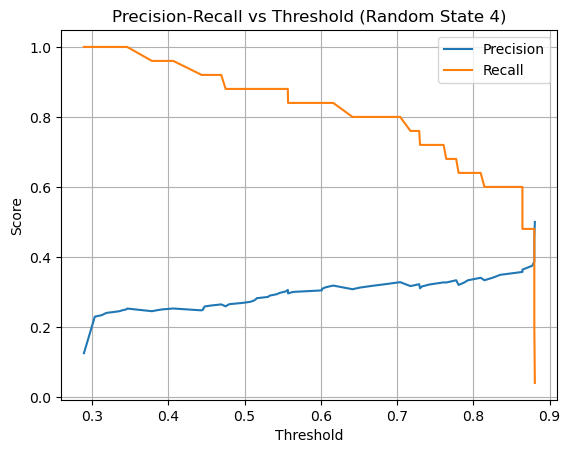

Best Threshold for F1-Score: 0.70
Test Metrics with Adjusted Threshold - Precision: 0.3279, Recall: 0.8000, F1-Score: 0.4651


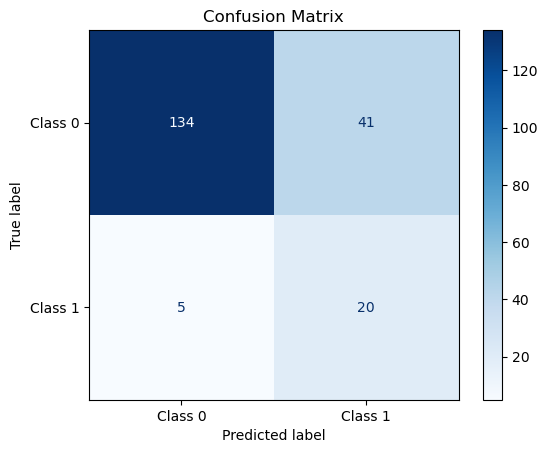

Random State 5
Best Parameters: {'ML_algo__learning_rate': 0.01, 'ML_algo__max_depth': 5, 'ML_algo__n_estimators': 150}


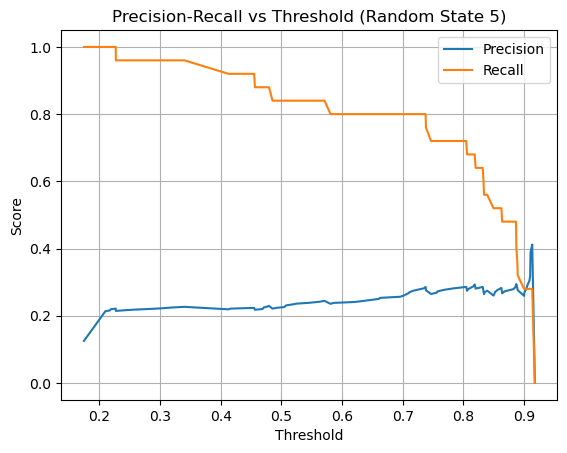

Best Threshold for F1-Score: 0.74
Test Metrics with Adjusted Threshold - Precision: 0.2857, Recall: 0.8000, F1-Score: 0.4211


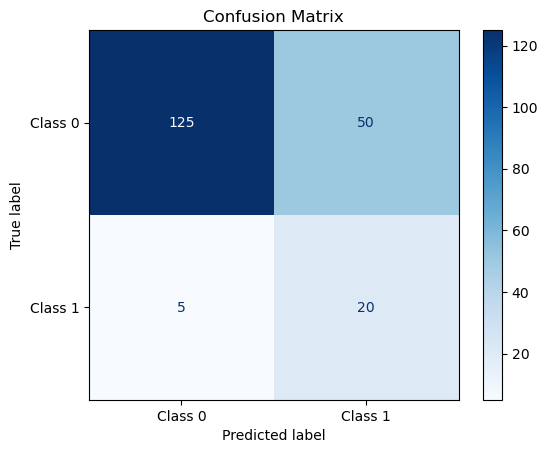

In [78]:
#xgb - smote

nr_states = 5
test_scores22 = np.zeros(nr_states)
best_thresholds22 = np.zeros(nr_states)
final_models22 = []
recalls22 = np.zeros(nr_states)
precisions22 = np.zeros(nr_states)
  # Assuming `prep` is already defined

for i in range(nr_states):
    print(f"Random State {i+1}")
    
    # Split data into training and test sets
    X_other, X_test, y_other, y_test = train_test_split(X,y,\
                    train_size = 0.8,stratify=y,random_state = 42*i)
    
    # Define parameter grid for RandomForestClassifier
    param_grid = {
    'ML_algo__max_depth': [5, 10, 15],
    'ML_algo__learning_rate': [0.01, 0.1, 0.2],
    'ML_algo__n_estimators': [50, 75, 100, 150, 200]
}


    # preprocess the sets
    X_other_prep = prep.fit_transform(X_other)
    
    # Define the pipeline with preprocessing and the model
    clf = ImbPipeline(steps=[
        ('smote', SMOTE(sampling_strategy=0.5, k_neighbors=10, random_state=42*i)),
        ('ML_algo', XGBClassifier(objective='binary:logistic', scale_pos_weight=9, random_state=42*i))
    ])
    
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    #StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(clf, param_grid, cv=kfold, scoring='f1',verbose=0, n_jobs=-1)
    grid_search.fit(X_other_prep, y_other)
        #print("Best parameters: ", grid_search.best_params_)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best Parameters: {best_params}")
    
    # Evaluate on validation and test sets
    X_test_prep = prep.transform(X_test)  # Transform the test data
    y_test_probs = best_model.predict_proba(X_test_prep)[:, 1]
    
    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs)
    
    # Plot Precision-Recall vs Threshold
    plt.figure()
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision-Recall vs Threshold (Random State {i+1})")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Compute F1-scores for each threshold
    f1_scores = [f1_score(y_test, (y_test_probs >= t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Best Threshold for F1-Score: {best_threshold:.2f}")
    
    # Evaluate using the best threshold
    y_test_pred_adjusted = (y_test_probs >= best_threshold).astype(int)
    precision_test = precision_score(y_test, y_test_pred_adjusted)
    recall_test = recall_score(y_test, y_test_pred_adjusted)
    f1_test = f1_score(y_test, y_test_pred_adjusted)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred_adjusted)
    precisions22[i] = precision_test
    recalls22[i] = recall_test
    test_scores22[i] = f1_test
    #ptrint detailed metrics
    print(f"Test Metrics with Adjusted Threshold - Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-Score: {f1_test:.4f}")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred_adjusted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
    final_models22.append(best_model)
    best_thresholds22[i] = best_threshold

In [79]:
print(test_scores21.mean())
print(test_scores22.mean())

0.42398647053054095
0.43086626076222156


Random State 1
Best Parameters: {'ML_algo__C': 0.1, 'ML_algo__gamma': 0.01}


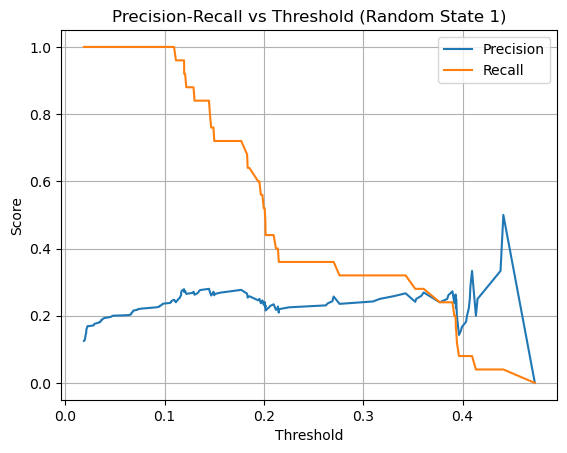

Best Threshold for F1-Score: 0.12
Test Metrics with Adjusted Threshold - Precision: 0.2791, Recall: 0.9600, F1-Score: 0.4324


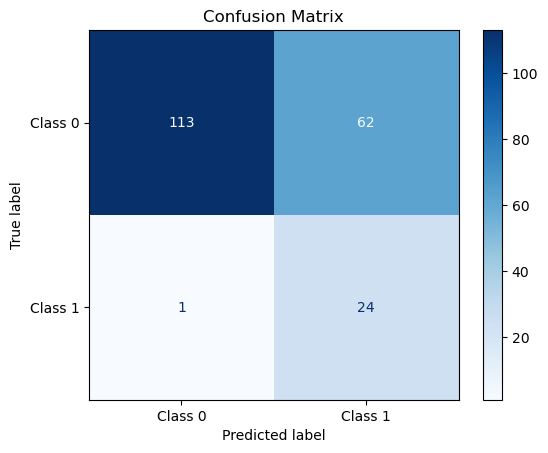

Random State 2
Best Parameters: {'ML_algo__C': 0.1, 'ML_algo__gamma': 0.01}


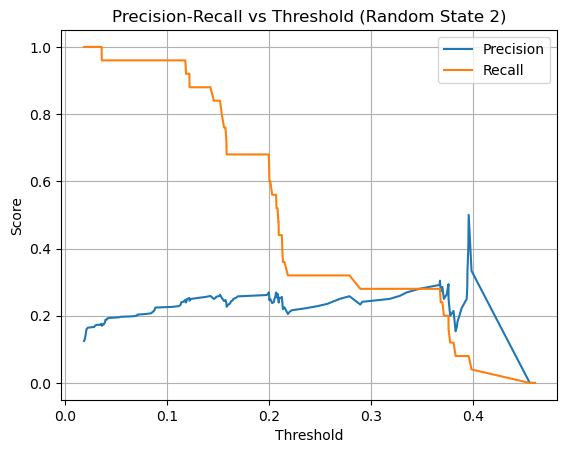

Best Threshold for F1-Score: 0.14
Test Metrics with Adjusted Threshold - Precision: 0.2588, Recall: 0.8800, F1-Score: 0.4000


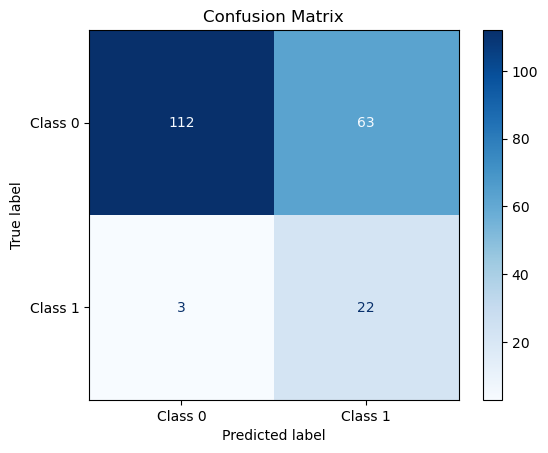

Random State 3
Best Parameters: {'ML_algo__C': 1.0, 'ML_algo__gamma': 0.1}


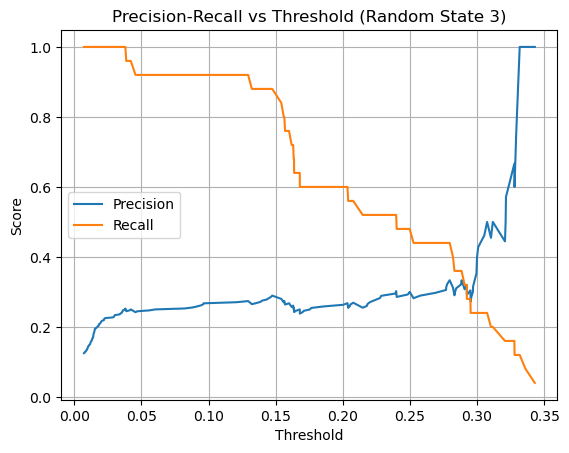

Best Threshold for F1-Score: 0.15
Test Metrics with Adjusted Threshold - Precision: 0.2895, Recall: 0.8800, F1-Score: 0.4356


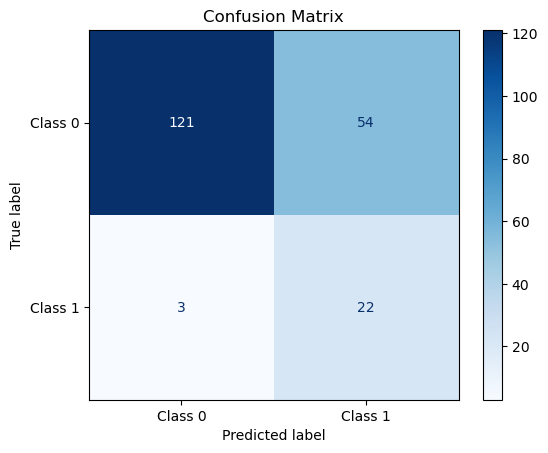

Random State 4
Best Parameters: {'ML_algo__C': 10.0, 'ML_algo__gamma': 0.01}


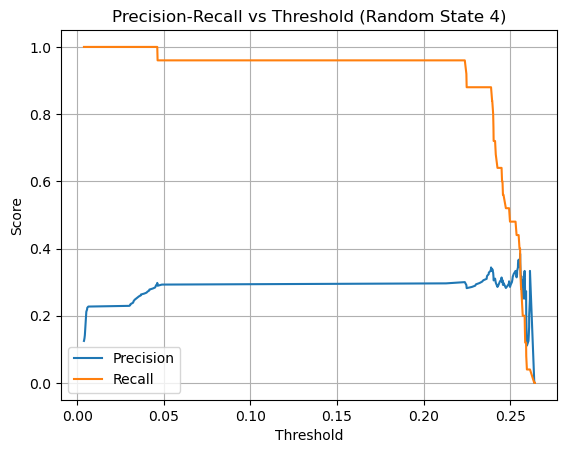

Best Threshold for F1-Score: 0.24
Test Metrics with Adjusted Threshold - Precision: 0.3438, Recall: 0.8800, F1-Score: 0.4944


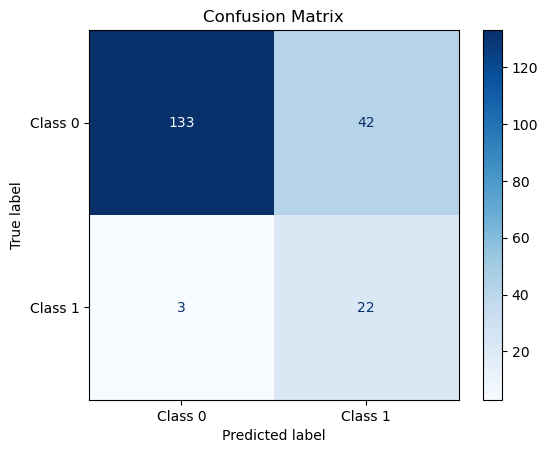

Random State 5
Best Parameters: {'ML_algo__C': 10.0, 'ML_algo__gamma': 0.01}


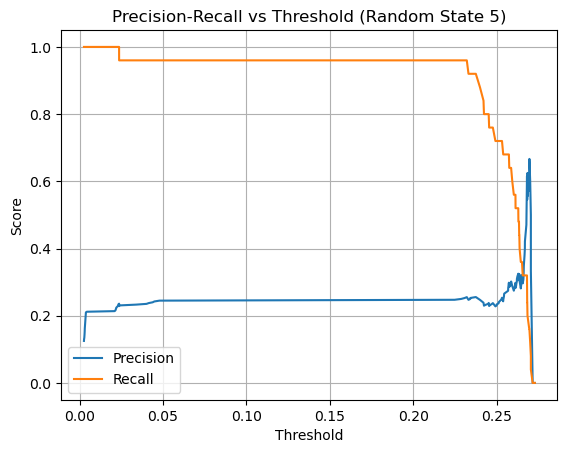

Best Threshold for F1-Score: 0.27
Test Metrics with Adjusted Threshold - Precision: 0.6154, Recall: 0.3200, F1-Score: 0.4211


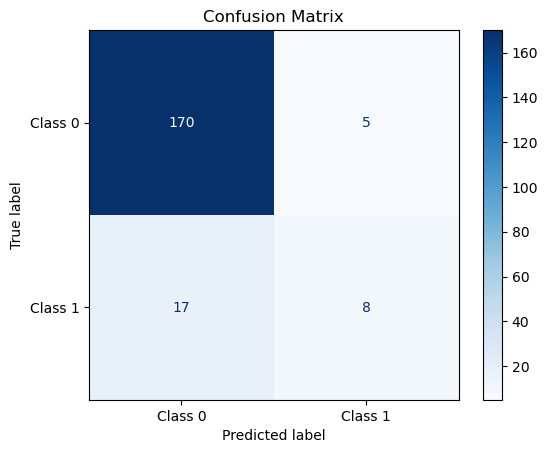

In [81]:
#svc
from sklearn.svm import SVC
nr_states = 5
test_scores31= np.zeros(nr_states)
best_thresholds31 = np.zeros(nr_states)
final_models31 = []
recalls31 = np.zeros(nr_states)
precisions31 = np.zeros(nr_states)
  # Assuming `prep` is already defined

for i in range(nr_states):
    print(f"Random State {i+1}")
    
    # Split data into training and test sets
    X_other, X_test, y_other, y_test = train_test_split(X,y,\
                    train_size = 0.8,stratify=y,random_state = 42*i)
    
    # Define parameter grid for RandomForestClassifier
    param_grid = {
    'ML_algo__C': [ 1e-1, 1e0, 1e1, 1e2,1e3],          # Regularization parameter
    'ML_algo__gamma': [ 1e-2, 1e-1, 1e0, 1e1] # Kernel coefficient #gamma 0.1,remove the two sides
}
       

    # preprocess the sets
    X_other_prep = prep.fit_transform(X_other)
    
    # Define the pipeline with preprocessing and the model
    clf = Pipeline(steps=[
        ('ML_algo', SVC(class_weight='balanced', probability=True, random_state=42))
    ])
    
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    #StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(clf, param_grid, cv=kfold, scoring='f1',verbose=0, n_jobs=-1)
    grid_search.fit(X_other_prep, y_other)
        #print("Best parameters: ", grid_search.best_params_)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best Parameters: {best_params}")

    # Evaluate on validation and test sets
    X_test_prep = prep.transform(X_test)  # Transform the test data
    y_test_probs = best_model.predict_proba(X_test_prep)[:, 1]
    
    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs)
    
    # Plot Precision-Recall vs Threshold
    plt.figure()
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision-Recall vs Threshold (Random State {i+1})")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Compute F1-scores for each threshold
    f1_scores = [f1_score(y_test, (y_test_probs >= t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Best Threshold for F1-Score: {best_threshold:.2f}")
    
    # Evaluate using the best threshold
    y_test_pred_adjusted = (y_test_probs >= best_threshold).astype(int)
    precision_test = precision_score(y_test, y_test_pred_adjusted)
    recall_test = recall_score(y_test, y_test_pred_adjusted)
    f1_test = f1_score(y_test, y_test_pred_adjusted)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred_adjusted)
    precisions31[i] = precision_test
    recalls31[i] = recall_test
    #ptrint detailed metrics
    print(f"Test Metrics with Adjusted Threshold - Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-Score: {f1_test:.4f}")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred_adjusted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
    
    final_models31.append(best_model)
    test_scores31[i] = f1_test
    best_thresholds31[i] = best_threshold

Random State 1
Best Parameters: {'ML_algo__C': 10.0, 'ML_algo__gamma': 0.01}


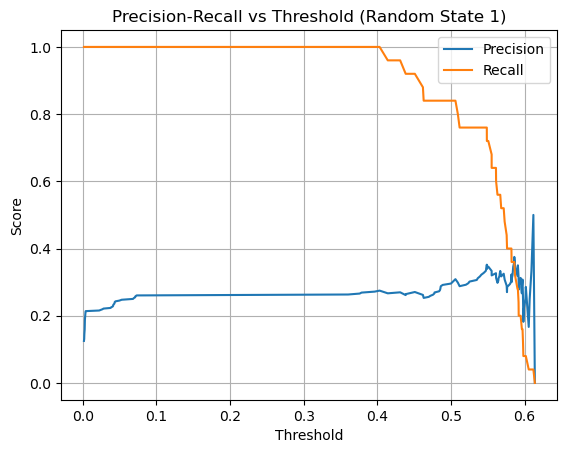

Best Threshold for F1-Score: 0.55
Test Metrics with Adjusted Threshold - Precision: 0.3519, Recall: 0.7600, F1-Score: 0.4810


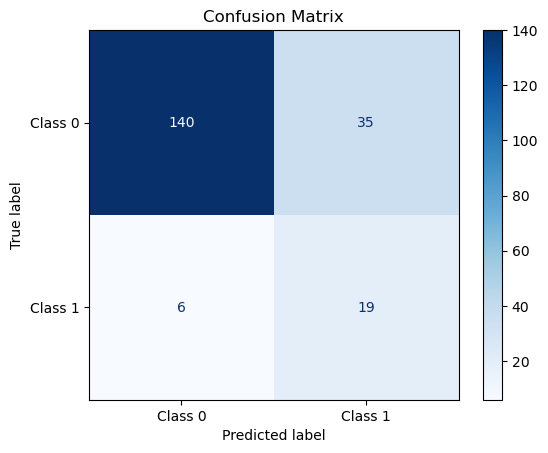

Random State 2
Best Parameters: {'ML_algo__C': 100.0, 'ML_algo__gamma': 0.01}


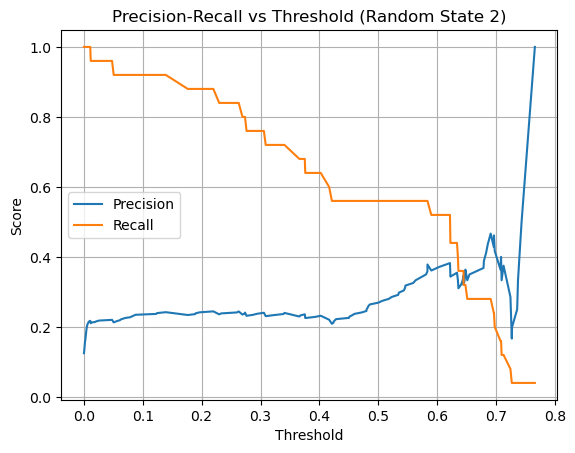

Best Threshold for F1-Score: 0.58
Test Metrics with Adjusted Threshold - Precision: 0.3784, Recall: 0.5600, F1-Score: 0.4516


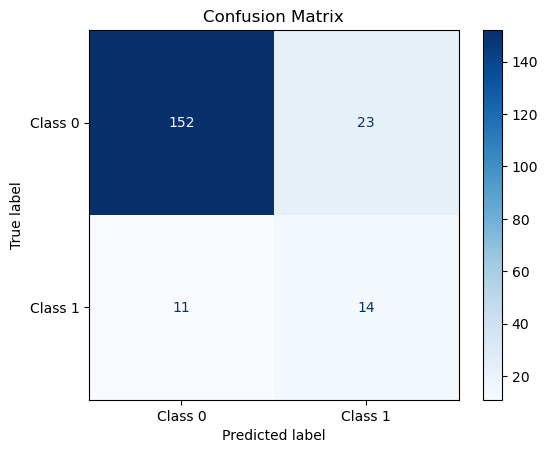

Random State 3
Best Parameters: {'ML_algo__C': 100.0, 'ML_algo__gamma': 0.01}


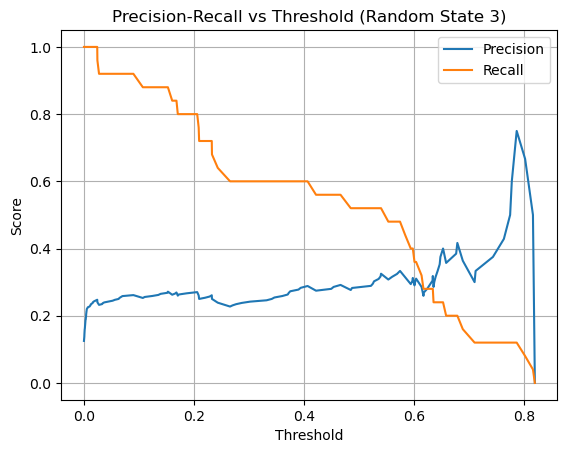

Best Threshold for F1-Score: 0.15
Test Metrics with Adjusted Threshold - Precision: 0.2716, Recall: 0.8800, F1-Score: 0.4151


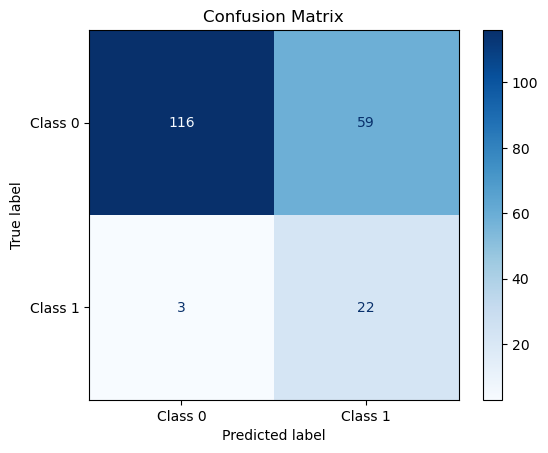

Random State 4
Best Parameters: {'ML_algo__C': 0.1, 'ML_algo__gamma': 0.01}


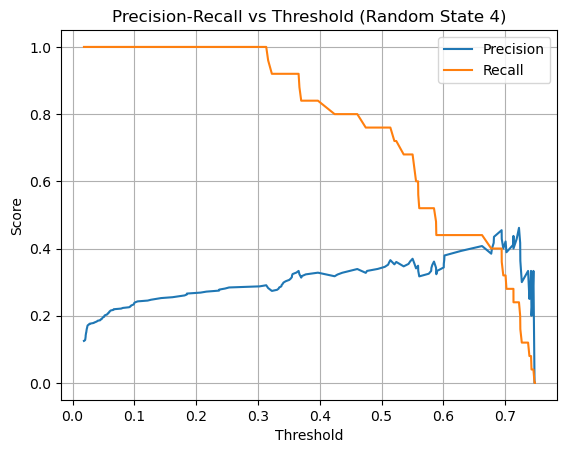

Best Threshold for F1-Score: 0.51
Test Metrics with Adjusted Threshold - Precision: 0.3654, Recall: 0.7600, F1-Score: 0.4935


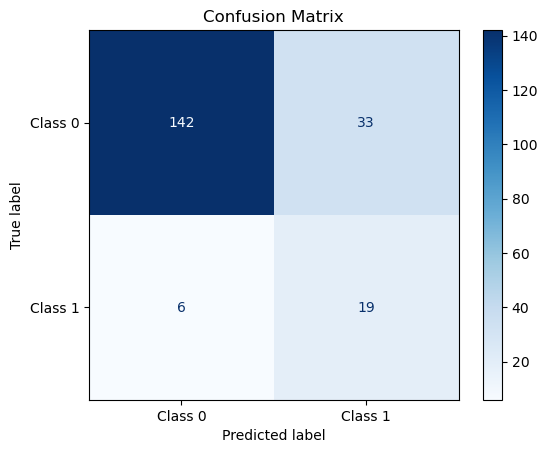

Random State 5
Best Parameters: {'ML_algo__C': 1.0, 'ML_algo__gamma': 0.1}


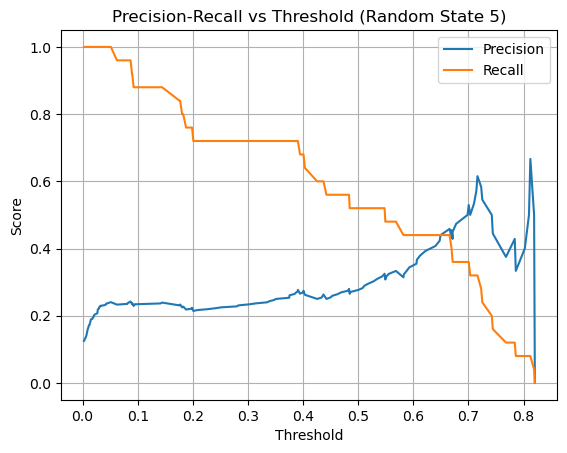

Best Threshold for F1-Score: 0.67
Test Metrics with Adjusted Threshold - Precision: 0.4583, Recall: 0.4400, F1-Score: 0.4490


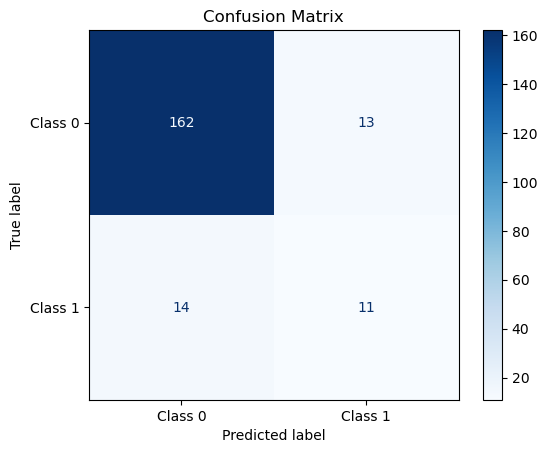

In [83]:
#svc - smote
nr_states = 5
test_scores32= np.zeros(nr_states)
best_thresholds32 = np.zeros(nr_states)
final_models32 = []
recalls32 = np.zeros(nr_states)
precisions32 = np.zeros(nr_states)
  # Assuming `prep` is already defined

for i in range(nr_states):
    print(f"Random State {i+1}")
    
    # Split data into training and test sets
    X_other, X_test, y_other, y_test = train_test_split(X,y,\
                    train_size = 0.8,stratify=y,random_state = 42*i)
    
    # Define parameter grid for RandomForestClassifier
    param_grid = {
    'ML_algo__C': [ 1e-1, 1e0, 1e1, 1e2,1e3],          # Regularization parameter
    'ML_algo__gamma': [ 1e-2, 1e-1, 1e0, 1e1] # Kernel coefficient #gamma 0.1,remove the two sides
}


    

    # preprocess the sets
    X_other_prep = prep.fit_transform(X_other)
    
    # Define the pipeline with preprocessing and the model
    clf = ImbPipeline(steps=[
        ('smote', SMOTE(sampling_strategy=0.5, k_neighbors=10, random_state=42*i)),
        ('ML_algo', SVC(class_weight='balanced', probability=True, random_state=42))
    ])
    
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    #StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(clf, param_grid, cv=kfold, scoring='f1',verbose=0, n_jobs=-1)
    grid_search.fit(X_other_prep, y_other)
        #print("Best parameters: ", grid_search.best_params_)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best Parameters: {best_params}")

    # Evaluate on validation and test sets
    X_test_prep = prep.transform(X_test)  # Transform the test data
    y_test_probs = best_model.predict_proba(X_test_prep)[:, 1]
    
    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs)
    
    # Plot Precision-Recall vs Threshold
    plt.figure()
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision-Recall vs Threshold (Random State {i+1})")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Compute F1-scores for each threshold
    f1_scores = [f1_score(y_test, (y_test_probs >= t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Best Threshold for F1-Score: {best_threshold:.2f}")
    
    # Evaluate using the best threshold
    y_test_pred_adjusted = (y_test_probs >= best_threshold).astype(int)
    precision_test = precision_score(y_test, y_test_pred_adjusted)
    recall_test = recall_score(y_test, y_test_pred_adjusted)
    f1_test = f1_score(y_test, y_test_pred_adjusted)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred_adjusted)
    precisions32[i] = precision_test
    recalls32[i] = recall_test
    #ptrint detailed metrics
    print(f"Test Metrics with Adjusted Threshold - Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-Score: {f1_test:.4f}")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred_adjusted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
    
    final_models32.append(best_model)
    test_scores32[i] = f1_test
    best_thresholds32[i] = best_threshold

Random State 1
Best Parameters: {'ML_algo__C': 10, 'ML_algo__penalty': 'l2'}


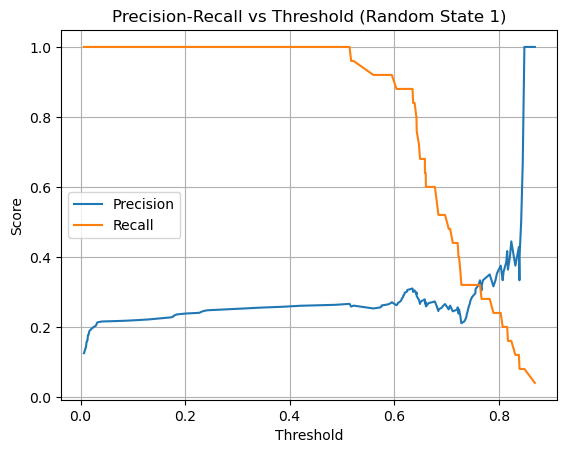

Best Threshold for F1-Score: 0.64
Test Metrics with Adjusted Threshold - Precision: 0.3099, Recall: 0.8800, F1-Score: 0.4583


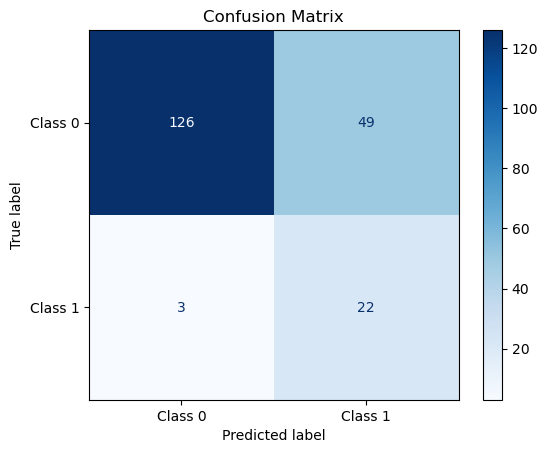

Random State 2
Best Parameters: {'ML_algo__C': 100, 'ML_algo__penalty': 'l2'}


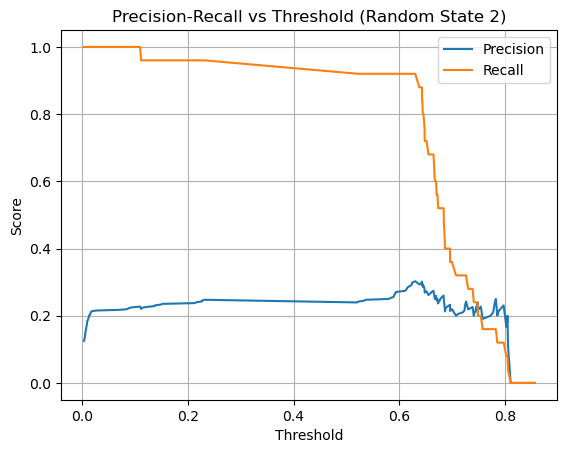

Best Threshold for F1-Score: 0.63
Test Metrics with Adjusted Threshold - Precision: 0.3026, Recall: 0.9200, F1-Score: 0.4554


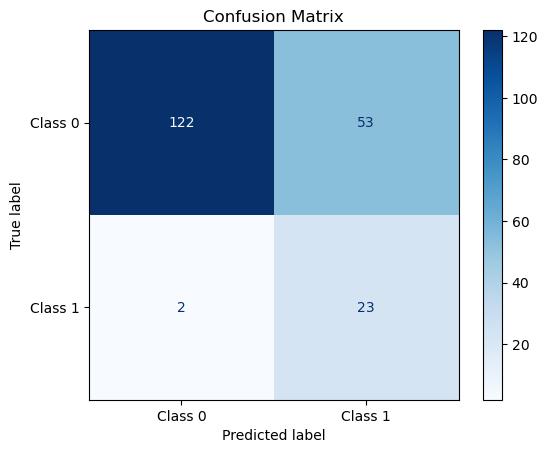

Random State 3
Best Parameters: {'ML_algo__C': 10, 'ML_algo__penalty': 'l2'}


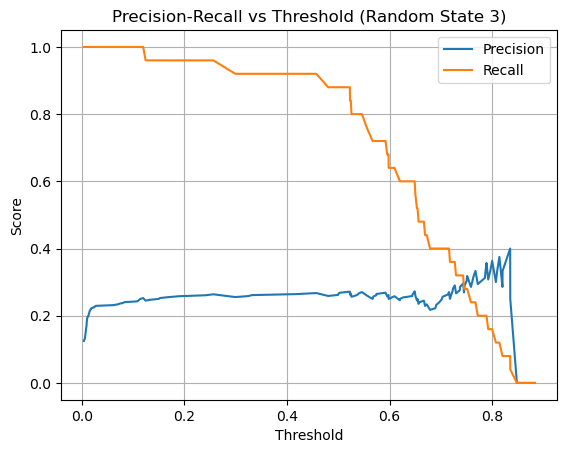

Best Threshold for F1-Score: 0.52
Test Metrics with Adjusted Threshold - Precision: 0.2716, Recall: 0.8800, F1-Score: 0.4151


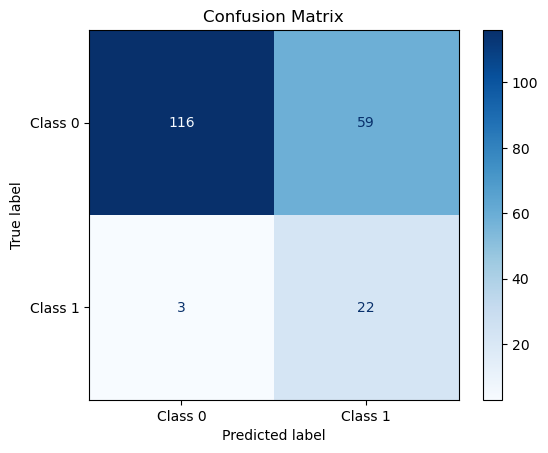

Random State 4
Best Parameters: {'ML_algo__C': 0.1, 'ML_algo__penalty': 'l2'}


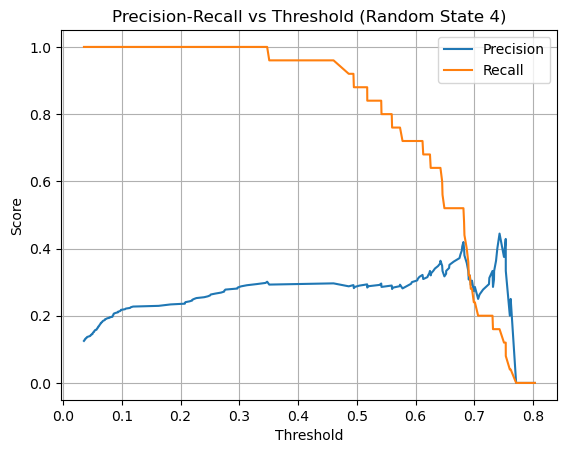

Best Threshold for F1-Score: 0.68
Test Metrics with Adjusted Threshold - Precision: 0.4194, Recall: 0.5200, F1-Score: 0.4643


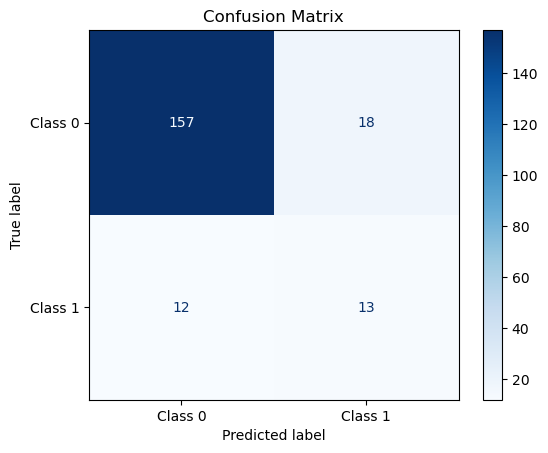

Random State 5
Best Parameters: {'ML_algo__C': 0.1, 'ML_algo__penalty': 'l2'}


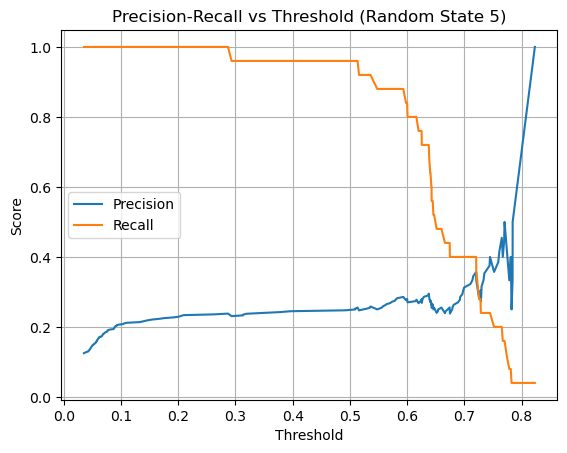

Best Threshold for F1-Score: 0.59
Test Metrics with Adjusted Threshold - Precision: 0.2857, Recall: 0.8800, F1-Score: 0.4314


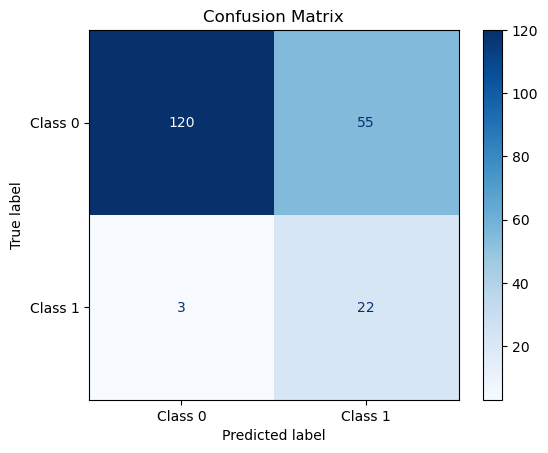

In [101]:
#logistic - l2
from sklearn.linear_model import LogisticRegression
nr_states = 5
test_scores41= np.zeros(nr_states)
best_thresholds41 = np.zeros(nr_states)
final_models41 = []
precisions41=np.zeros(nr_states)
recalls41=np.zeros(nr_states)
  # Assuming `prep` is already defined

for i in range(nr_states):
    print(f"Random State {i+1}")
    
    # Split data into training and test sets
    X_other, X_test, y_other, y_test = train_test_split(X,y,\
                    train_size = 0.8,stratify=y,random_state = 42*i)
    
    # Define parameter grid for RandomForestClassifier

    param_grid = {
    'ML_algo__C': [ 0.1, 1, 10, 100,200],     # Regularization strength (inverse of regularization)
    'ML_algo__penalty': ['l2']  # L2 regularization (ridge)
} # Kernel coefficient #gamma 0.1,remove the two sides

       

    # preprocess the sets
    X_other_prep = prep.fit_transform(X_other)
    
    # Define the pipeline with preprocessing and the model
    clf = Pipeline(steps=[
        ('ML_algo', LogisticRegression(class_weight='balanced', random_state=42*i, max_iter=1000))
    ])
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    #StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(clf, param_grid, cv=kfold, scoring='f1',verbose=0, n_jobs=-1)
    grid_search.fit(X_other_prep, y_other)
        #print("Best parameters: ", grid_search.best_params_)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best Parameters: {best_params}")

    # Evaluate on validation and test sets
    X_test_prep = prep.transform(X_test)  # Transform the test data
    y_test_probs = best_model.predict_proba(X_test_prep)[:, 1]
    
    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs)
    
    # Plot Precision-Recall vs Threshold
    plt.figure()
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision-Recall vs Threshold (Random State {i+1})")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Compute F1-scores for each threshold
    f1_scores = [f1_score(y_test, (y_test_probs >= t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Best Threshold for F1-Score: {best_threshold:.2f}")
    
    # Evaluate using the best threshold
    y_test_pred_adjusted = (y_test_probs >= best_threshold).astype(int)
    precision_test = precision_score(y_test, y_test_pred_adjusted)
    recall_test = recall_score(y_test, y_test_pred_adjusted)
    f1_test = f1_score(y_test, y_test_pred_adjusted)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred_adjusted)
    recalls41[i] = recall_test
    precisions41[i] = precision_test
    #ptrint detailed metrics
    print(f"Test Metrics with Adjusted Threshold - Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-Score: {f1_test:.4f}")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred_adjusted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
    
    
    final_models41.append(best_model)
    test_scores41[i] = f1_test
    best_thresholds41[i] = best_threshold

Random State 1
Best Parameters: {'ML_algo__C': 10, 'ML_algo__penalty': 'l2'}


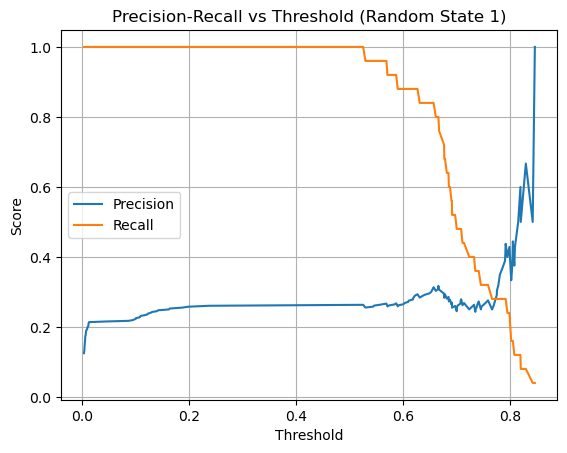

Best Threshold for F1-Score: 0.66
Test Metrics with Adjusted Threshold - Precision: 0.3134, Recall: 0.8400, F1-Score: 0.4565


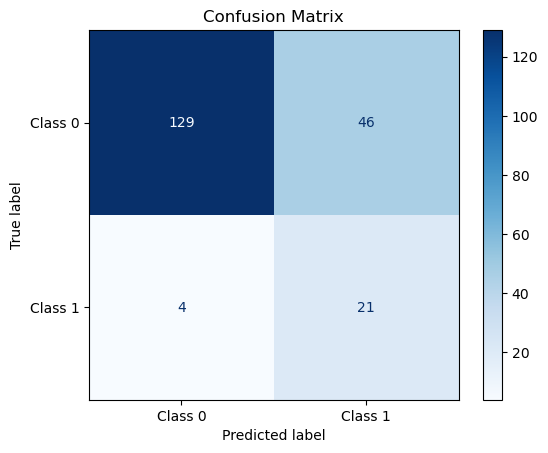

Random State 2
Best Parameters: {'ML_algo__C': 0.1, 'ML_algo__penalty': 'l2'}


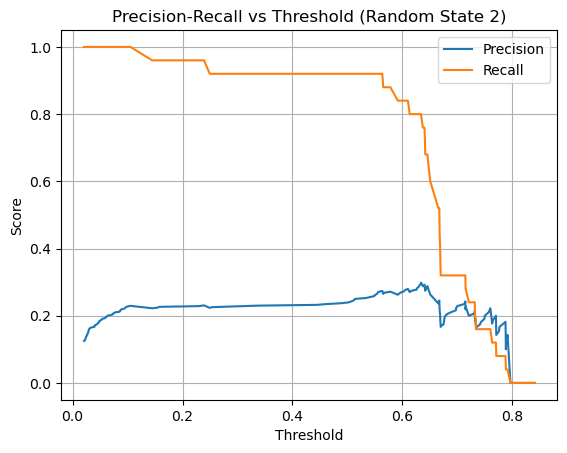

Best Threshold for F1-Score: 0.63
Test Metrics with Adjusted Threshold - Precision: 0.2985, Recall: 0.8000, F1-Score: 0.4348


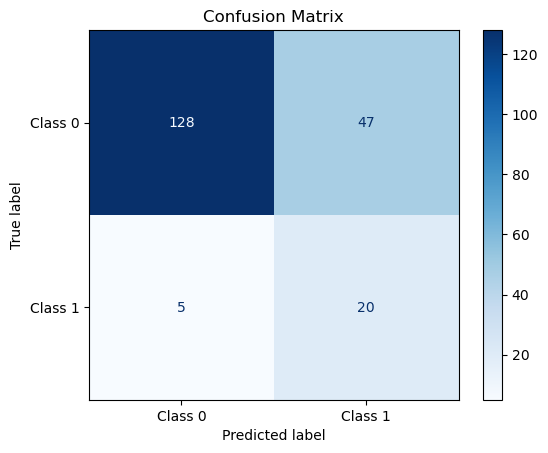

Random State 3
Best Parameters: {'ML_algo__C': 10, 'ML_algo__penalty': 'l2'}


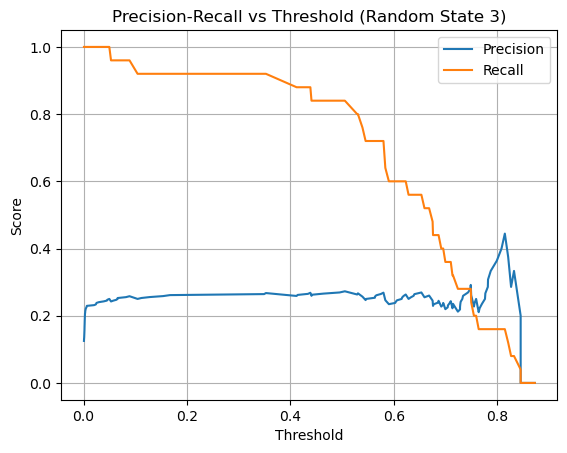

Best Threshold for F1-Score: 0.35
Test Metrics with Adjusted Threshold - Precision: 0.2674, Recall: 0.9200, F1-Score: 0.4144


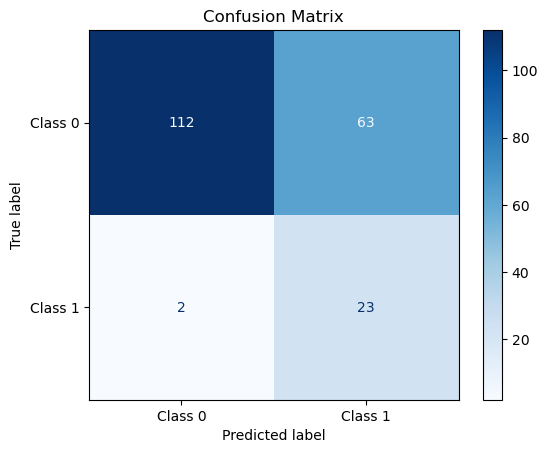

Random State 4
Best Parameters: {'ML_algo__C': 1, 'ML_algo__penalty': 'l2'}


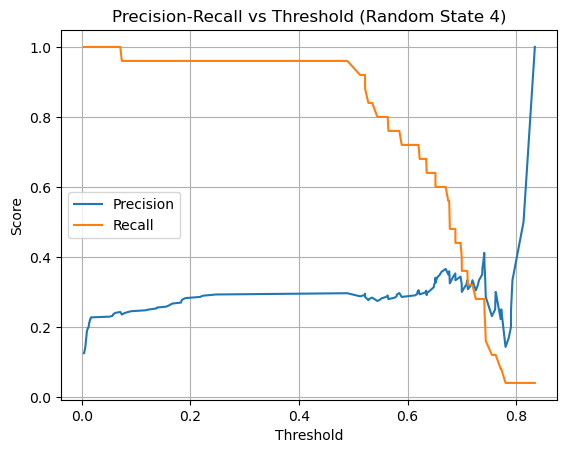

Best Threshold for F1-Score: 0.67
Test Metrics with Adjusted Threshold - Precision: 0.3659, Recall: 0.6000, F1-Score: 0.4545


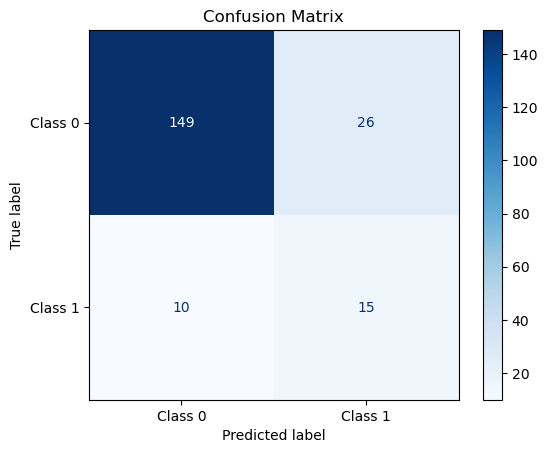

Random State 5
Best Parameters: {'ML_algo__C': 0.1, 'ML_algo__penalty': 'l2'}


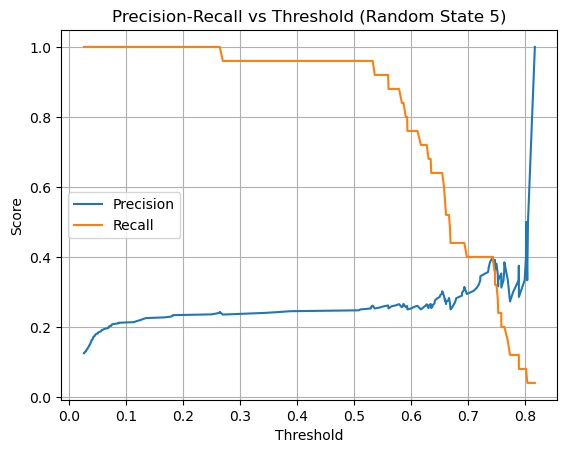

Best Threshold for F1-Score: 0.53
Test Metrics with Adjusted Threshold - Precision: 0.2609, Recall: 0.9600, F1-Score: 0.4103


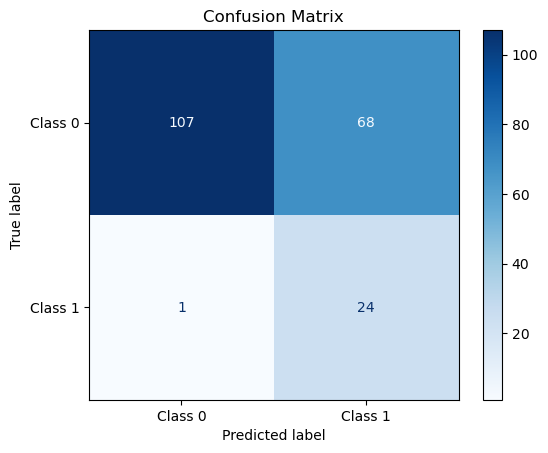

In [92]:
#smote logistic
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
nr_states = 5
test_scores42= np.zeros(nr_states)
best_thresholds42 = np.zeros(nr_states)
final_models42 = []
recalls42 = np.zeros(nr_states)
precisions42 = np.zeros(nr_states)
  # Assuming `prep` is already defined

for i in range(nr_states):
    print(f"Random State {i+1}")
    
    # Split data into training and test sets
    X_other, X_test, y_other, y_test = train_test_split(X,y,\
                    train_size = 0.8,stratify=y,random_state = 42*i)
    
    # Define parameter grid for RandomForestClassifier

    param_grid = {
    'ML_algo__C': [ 0.1, 1, 10, 100,200],     # Regularization strength (inverse of regularization)
    'ML_algo__penalty': ['l2']  # L2 regularization (ridge)
} # Kernel coefficient #gamma 0.1,remove the two sides

       

    # preprocess the sets
    X_other_prep = prep.fit_transform(X_other)
    
    # Define the pipeline with preprocessing and the model
    clf = ImbPipeline(steps=[
        ('smote', SMOTE(sampling_strategy=0.5, k_neighbors=10, random_state=42*i)),
        ('ML_algo', LogisticRegression(class_weight='balanced', random_state=42*i, max_iter=1000))
    ])
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    #StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(clf, param_grid, cv=kfold, scoring='f1',verbose=0, n_jobs=-1)
    grid_search.fit(X_other_prep, y_other)
        #print("Best parameters: ", grid_search.best_params_)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best Parameters: {best_params}")

    # Evaluate on validation and test sets
    X_test_prep = prep.transform(X_test)  # Transform the test data
    y_test_probs = best_model.predict_proba(X_test_prep)[:, 1]
    
    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs)
    
    # Plot Precision-Recall vs Threshold
    plt.figure()
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision-Recall vs Threshold (Random State {i+1})")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Compute F1-scores for each threshold
    f1_scores = [f1_score(y_test, (y_test_probs >= t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Best Threshold for F1-Score: {best_threshold:.2f}")
    
    # Evaluate using the best threshold
    y_test_pred_adjusted = (y_test_probs >= best_threshold).astype(int)
    precision_test = precision_score(y_test, y_test_pred_adjusted)
    recall_test = recall_score(y_test, y_test_pred_adjusted)
    f1_test = f1_score(y_test, y_test_pred_adjusted)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred_adjusted)
    precisions42[i] = precision_test
    recalls42[i] = recall_test
    #ptrint detailed metrics
    print(f"Test Metrics with Adjusted Threshold - Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1-Score: {f1_test:.4f}")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred_adjusted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
    
    
    final_models42.append(best_model)
    test_scores42[i] = f1_test
    best_thresholds42[i] = best_threshold

In [103]:
test_scores42.mean()

0.43410412540847326

In [104]:
test_scores41.mean()

0.44490629616315047

## feature importance

In [7]:
#premutation
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
import xgboost



X_other, X_test, y_other, y_test = train_test_split(X,y,\
                    train_size = 0.8,stratify=y,random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_other,y_other,\
                    train_size = 0.75,stratify=y_other,random_state = 42)
# parameters to try 
param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}
feature_names = prep.get_feature_names_out()
# fit_transform the training set
X_prep = prep.fit_transform(X_train)
df_val= prep.transform(X_val)
# transform the test
df_test = prep.transform(X_test)

XGB = xgboost.XGBRegressor(early_stopping_rounds=50)
XGB.set_params(**ParameterGrid(param_grid)[0])

# fit model to train data 
XGB.fit(X_prep,y_train,eval_set=[(df_val, y_val)], verbose=False)
perm_importance = permutation_importance(XGB, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

sorted_idx = perm_importance.importances_mean.argsort()[-10:][::-1] 
top_features = [feature_names[i] for i in sorted_idx] 
top_importances = perm_importance.importances_mean[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances) 
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features based on Permutation Importance") 
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Gender: object, Vehicle_Age: object, Vehicle_Damage: object

/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


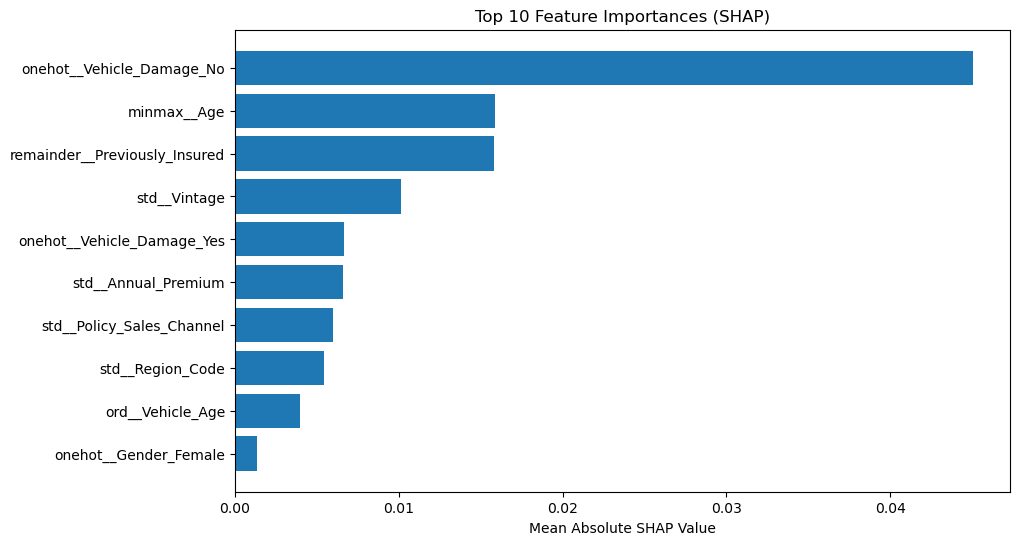

In [106]:
#shap
import shap

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(XGB)
shap_values = explainer(df_test)

mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
sorted_idx = np.argsort(mean_abs_shap_values)[-10:][::-1] 


top_features = np.array(feature_names)[sorted_idx]
top_shap_values = mean_abs_shap_values[sorted_idx]


plt.figure(figsize=(10, 6))
plt.barh(top_features, top_shap_values, align="center")
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Top 10 Feature Importances (SHAP)")
plt.gca().invert_yaxis()
plt.show()

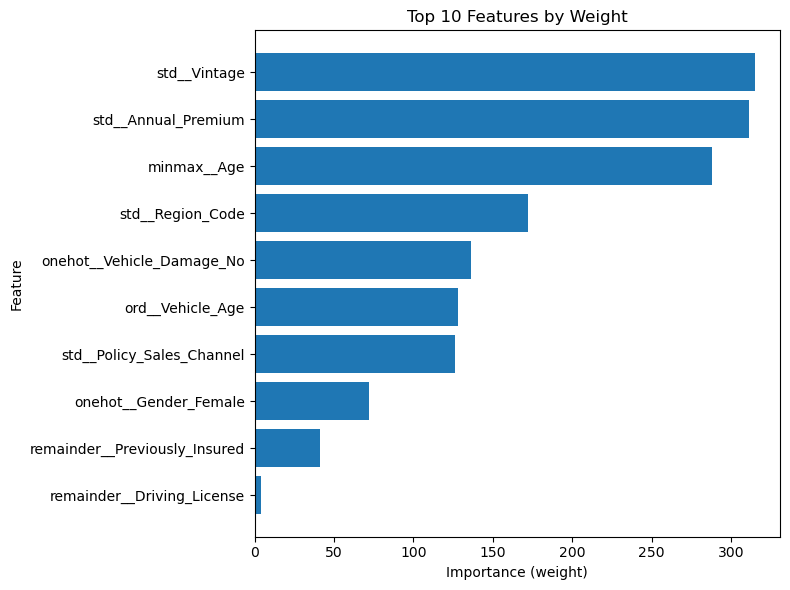

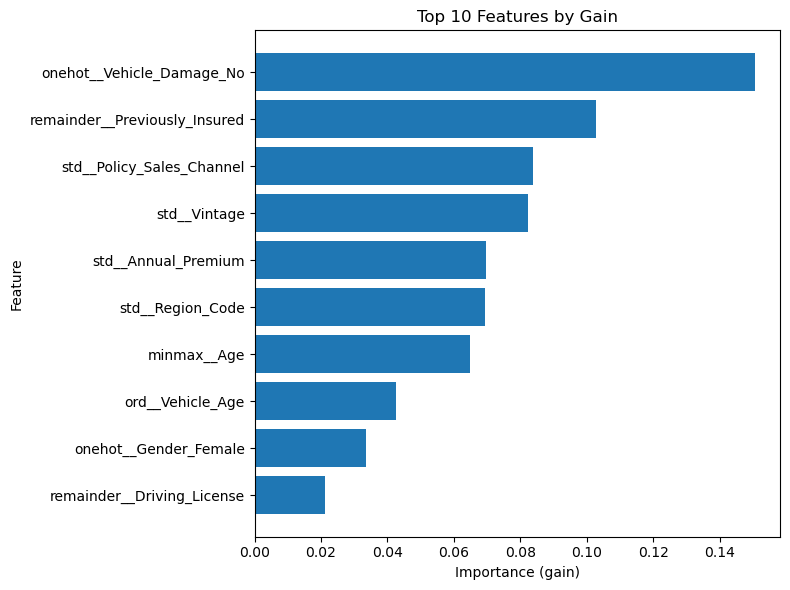

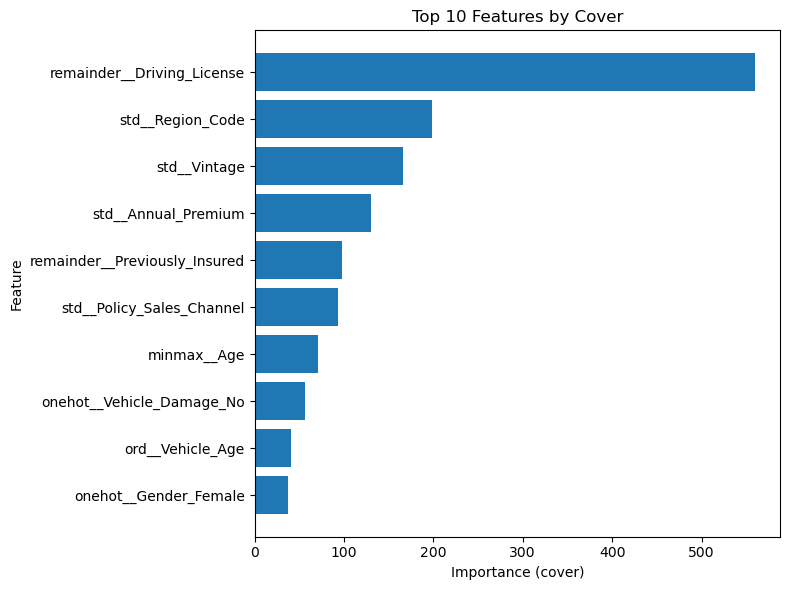

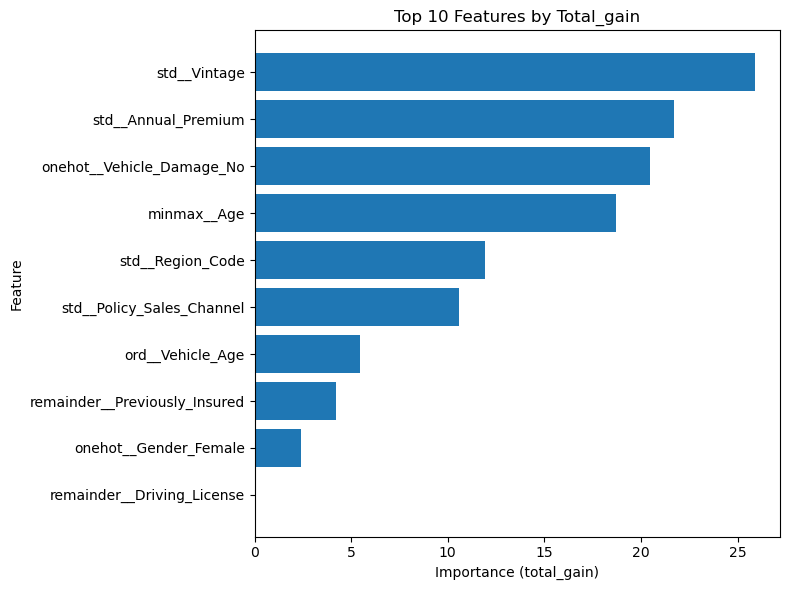

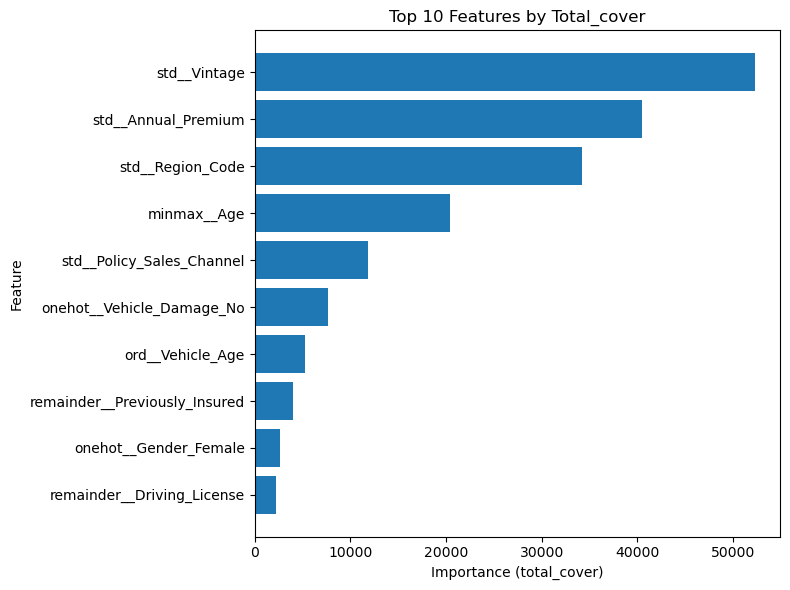

In [109]:
metrics = ["weight", "gain", "cover", "total_gain", "total_cover"]

# Map XGBoost's internal feature names (f0, f1, ...) to actual feature names
feature_map = {f"f{i}": name for i, name in enumerate(feature_names)}

# Extract feature importance and map feature names
feature_importance = {
    metric: {
        feature_map.get(k, k): v  # Replace XGBoost feature names with actual names
        for k, v in XGB.get_booster().get_score(importance_type=metric).items()
    }
    for metric in metrics
}

# Convert importance into DataFrames
importance_dfs = {
    metric: pd.DataFrame(list(importance.items()), columns=["Feature", metric])
    for metric, importance in feature_importance.items()
}

# Sort and select the top 10 features for each metric
sorted_importance_dfs = {
    metric: df.sort_values(by=metric, ascending=False).head(10)
    for metric, df in importance_dfs.items()
}

# Plot top 10 features by each metric
for metric, df in sorted_importance_dfs.items():
    plt.figure(figsize=(8, 6))
    plt.barh(df["Feature"][::-1], df[metric][::-1])  # Reverse for descending order
    plt.xlabel(f"Importance ({metric})")
    plt.ylabel("Feature")
    plt.title(f"Top 10 Features by {metric.capitalize()}")
    plt.tight_layout()
    plt.show()
